In [68]:
from pyciemss import PetriNetODE

In [69]:
import os

from pyciemss.PetriNetODE.base import BetaNoisePetriNetODESystem
from pyciemss.PetriNetODE.interfaces import load_petri_model, setup_model, sample, calibrate
import pyciemss
import numpy as np

Let's see what directory we're in

In [70]:
os.getcwd()

'/home/chads/git/pyciemss/notebook'

Most of our files are relative to `test/models/`, so we need to go up a directory.

In [75]:
PYCIEMSS_PATH = ".."
STARTERKIT_PATH = os.path.join(PYCIEMSS_PATH, "test/models/starter_kit_examples/")
MIRA_PATH = os.path.join(PYCIEMSS_PATH, "test/models/evaluation_examples/")

filename = "CHIME-SIR/model_petri.json"
filename = os.path.join(STARTERKIT_PATH, filename)

model = load_petri_model(filename, add_uncertainty=True)
model = setup_model(model, start_time=0.0, start_state=dict(S=0.99, I=0.01, R=0.0))

In [76]:
model

BetaNoisePetriNetODESystem()

It would be useful to give more details here. What are the parameters or parameter priors? What's the pseudocount for the Beta?

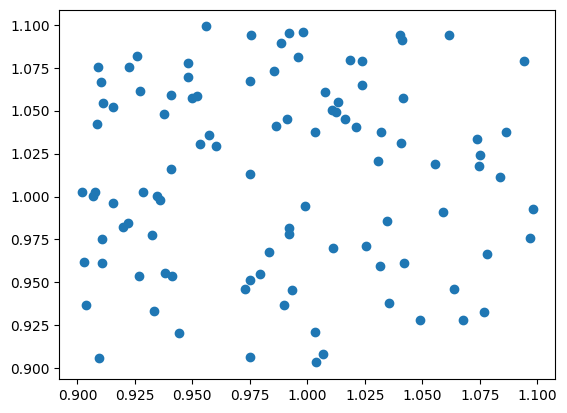

In [90]:
from matplotlib import pyplot as plt

plt.scatter(data["a_beta"], data["a_gamma"])

In [77]:
import matplotlib.pyplot as plt

def plot_sample(times, s, names, alpha=1, **kwargs):
    for i,name in enumerate(names):
        for trajectory in s[name]:
            plt.plot(times, trajectory, label=name, alpha=alpha, color='C' + str(i), **kwargs)

In [78]:
times = np.linspace(0.01, 30, 100)
num_samples = 100
data = sample(model, times, num_samples)

In [79]:
observed_indices = np.sort(np.random.choice(range(0,100), 10, replace=False))
observed_indices

array([23, 28, 60, 64, 70, 79, 83, 85, 88, 92])

In [80]:
import pyro
mu = data['I_sol'][0][observed_indices]
obs_times = times[observed_indices]
obs_vals = pyro.distributions.Beta(mu * 10000, (1 - mu) * 10000).sample()

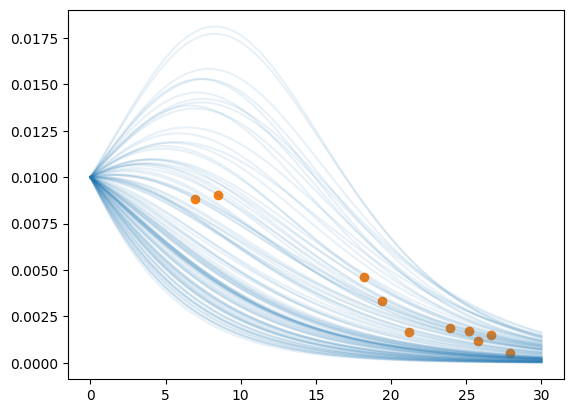

In [81]:
plot_sample(times, data, ('I_sol',), alpha=0.1)
plt.scatter(obs_times, obs_vals, color='C1')

In [82]:
obs = [(times[j], 
        {var: float(data[var + "_sol"][0,j]) for var in ["S", "I", "R"]})
    for j in observed_indices]

In [83]:
len(obs)

10

In [84]:
post = calibrate(model, obs)
post

AutoNormal(
  (locs): PyroModule()
  (scales): PyroModule()
)

In [85]:
post_sample = sample(model, np.linspace(0.01, 30, 100), 100, inferred_parameters=post)

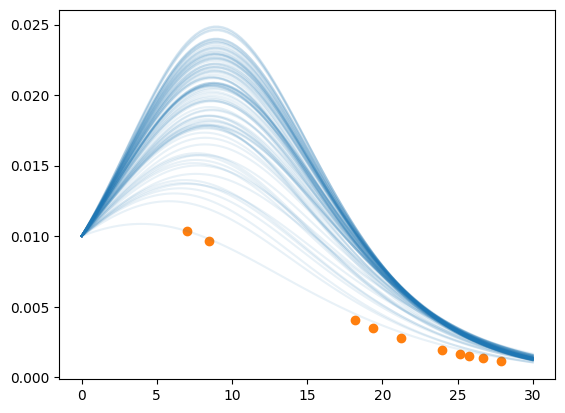

In [86]:
plot_sample(times, post_sample, ('I_sol',), alpha=0.1)
plt.scatter(times[observed_indices], data['I_sol'][0][observed_indices], color='C1')